In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [2]:
train_data_raw = pd.read_csv('./Dataset/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./Dataset/sign_mnist_test.csv', sep=",")

In [3]:
train_data_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train_labels = train_data_raw['label']
train_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

test_labels = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

In [5]:
train_labels.shape

(27455,)

In [6]:
train_data = train_data_raw.values
train_labels = train_labels.values

test_data = test_data_raw.values
test_labels = test_labels.values

In [7]:
train_labels.shape

(27455,)

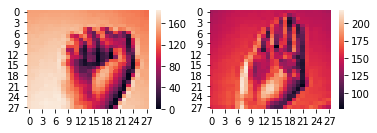

In [8]:
pixels = train_data[20].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_data[30].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

In [9]:
reshaped_train = []
for i in train_data:
    reshaped_train.append(i.reshape(1, 28, 28))
train_data = np.array(reshaped_train)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1, 28, 28))
test_data = np.array(reshaped_train)

In [10]:
train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_labels.tolist())

test_x = torch.FloatTensor(train_data)
test_y = torch.LongTensor(train_labels.tolist())

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        
        return(x)
        
    def test(self, predictions,labels):
        self.eval()
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)
    
    def evaluate(self, predictions,labels):
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)

In [12]:
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model = Network().cuda()

In [13]:
summary(model, (1,28,28)) #takes the model and the input tensor shape, displays the output shape/

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Conv2d-5             [-1, 30, 3, 3]           5,430
         Dropout2d-6             [-1, 30, 3, 3]               0
            Linear-7                  [-1, 270]          73,170
            Linear-8                   [-1, 26]           7,046
        LogSoftmax-9                   [-1, 26]               0
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.33
Estimated Total Size (MB): 0.43
---------------------------------------------

In [14]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [15]:
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.007)
criterion = nn.CrossEntropyLoss()

In [16]:
# def train(epochs, model, optimizer, criterion, use_cuda):
#     loss_log = []
#     acc_log = []

#     for epoch in range(1, epochs+1):
#         train_loss = 0.0
        
#         model.train()
        
#         for index, data in enumerate(train_data):
#             target = train_labels[index]
            
#             if use_cuda:
#                 data.cuda()
# #                 target.cuda()
                
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
            
#             if index%1000==0:
#                 loss_log.append(loss.item())
#                 acc_log.append(net.evaluate(torch.max(net(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
            
            
#             # print training/validation statistics 
#             print('Epoch: {} \tTraining Loss: {:.6f} '.format(
#                 epoch, 
#                 train_loss
#                 ))

            
#     # return trained model
#     return model

In [17]:
# # train the model
# model_scratch = train(epochs, model, optimizer, criterion, use_cuda)

In [18]:
from torch.autograd import Variable

In [19]:
# train_y[i:i + 100].head()

In [20]:
loss_log = []
acc_log = []

for e in range(50):
    for i in range(0, train_x.shape[0], 100):
        x_mini = train_x[i:i + 100] 
        y_mini = train_y[i:i + 100] 
        
        if use_cuda:
            x_mini = x_mini.cuda()
            y_mini = y_mini.cuda()
            test_x = test_x.cuda()
            test_y = test_y.cuda()
        
        optimizer.zero_grad()
        net_out = model(Variable(x_mini))
        
        loss = criterion(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(model.evaluate(torch.max(model(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.876677
Epoch: 2 - Loss: 2.489212
Epoch: 3 - Loss: 2.012761
Epoch: 4 - Loss: 1.461175
Epoch: 5 - Loss: 1.359220
Epoch: 6 - Loss: 1.075737
Epoch: 7 - Loss: 0.915236
Epoch: 8 - Loss: 0.879234
Epoch: 9 - Loss: 0.741629
Epoch: 10 - Loss: 0.726557
Epoch: 11 - Loss: 0.359653
Epoch: 12 - Loss: 0.372326
Epoch: 13 - Loss: 0.247068
Epoch: 14 - Loss: 0.213826
Epoch: 15 - Loss: 0.212687
Epoch: 16 - Loss: 0.206590
Epoch: 17 - Loss: 0.141472
Epoch: 18 - Loss: 0.157680
Epoch: 19 - Loss: 0.173072
Epoch: 20 - Loss: 0.137315
Epoch: 21 - Loss: 0.123230
Epoch: 22 - Loss: 0.101172
Epoch: 23 - Loss: 0.051900
Epoch: 24 - Loss: 0.049608
Epoch: 25 - Loss: 0.034232
Epoch: 26 - Loss: 0.146855
Epoch: 27 - Loss: 0.081444
Epoch: 28 - Loss: 0.048108
Epoch: 29 - Loss: 0.066347
Epoch: 30 - Loss: 0.084329
Epoch: 31 - Loss: 0.047425
Epoch: 32 - Loss: 0.048169
Epoch: 33 - Loss: 0.017336
Epoch: 34 - Loss: 0.019786
Epoch: 35 - Loss: 0.008886
Epoch: 36 - Loss: 0.011403
Epoch: 37 - Loss: 0.029887
Epoch: 38 

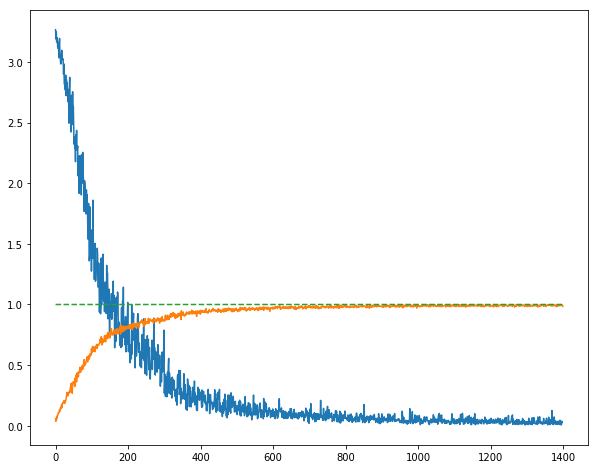

In [21]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')
plt.show()

In [22]:
predictions = model(Variable(test_x))
model.test(torch.max(predictions.data, 1)[1], test_y)

0.9906392278273538